In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import configs

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

# Parameters

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
checkpoints_dir = f'{engram_dir}checkpoints/'
tensorboard_dir = f'{engram_dir}tensorboard/'
activations_dir = f'{engram_dir}activations_pnet_all/'
pickles_dir = f'{engram_dir}pickles/'

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda:0


# Save correlations with shuffles/mean-subtraction

In [4]:
file_prefix = 'repr_pearsonr'
shuff_file_prefix = 'shuffle_pearsonr'
bgs = ['AudScene', 'Babble8Spkr']
snrs = [-9.0, -6.0, -3.0, 0.0, 3.0]

In [5]:
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']

In [6]:
n_timestep = 5

In [16]:
unit = {}
for layer in layers:
    unit[layer] = {}
    for timestep in range(n_timestep):
        unit[layer][timestep] = {
            'corr': 0, 'corr_norm': 0,
            'corr_mean_sub': 0, 'corr_norm_mean_sub': 0,
            'count': 0
            }

In [17]:
for bg in bgs:
    for snr in snrs:
        print(f'{bg}, SNR {snr}')        
        with open(f'{pickles_dir}{file_prefix}_{bg}_snr{snr}.p', 'rb') as f:
            results = pickle.load(f)
            
        # Load layer shuffle results
        with open(f'{pickles_dir}{shuff_file_prefix}_{bg}_snr{snr}.p', 'rb') as f:
            shuff_results = pickle.load(f)
        
        unit_shuff = {}
        for l in layers:
            unit_shuff[l] = np.nanmean(np.array(
                shuff_results['unit_shuffle'])[
                np.array(shuff_results['unit_layer'])==l
                ])

        # Calculate unit normalized and un-normalized correlations
        for i in range(len(results['unit_layer'])):
            layer = results['unit_layer'][i]
            if layer not in layers: continue
            corr = results['unit_shuffle'][i]
            corr_norm = corr/unit_shuff[layer]
            if np.isnan(corr): continue
            timestep = results['unit_timestep'][i]
            unit[layer][timestep]['corr'] += corr
            unit[layer][timestep]['corr_norm'] += corr_norm
            unit[layer][timestep]['count'] += 1

AudScene, SNR -9.0
AudScene, SNR -6.0
AudScene, SNR -3.0
AudScene, SNR 0.0
AudScene, SNR 3.0
Babble8Spkr, SNR -9.0
Babble8Spkr, SNR -6.0
Babble8Spkr, SNR -3.0
Babble8Spkr, SNR 0.0
Babble8Spkr, SNR 3.0


In [18]:
for layer in layers:
    for timestep in range(n_timestep):
        unit[layer][timestep]['corr'] /= unit[layer][timestep]['count']
        unit[layer][timestep]['corr_norm'] /= unit[layer][timestep]['count']

In [19]:
# Calculate popln mean subtractions
for layer in layers:
    for timestep in range(n_timestep):
        unit[layer][timestep]['corr_mean_sub'] = unit[layer][timestep]['corr'] - unit[layer][0]['corr']
        unit[layer][timestep]['corr_norm_mean_sub'] = unit[layer][timestep]['corr_norm'] - unit[layer][0]['corr_norm']

In [ ]:
with open(f'{pickles_dir}{file_prefix}_unit_collected.p', 'wb') as f:
    pickle.dump(unit, f)

# Across Timesteps

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


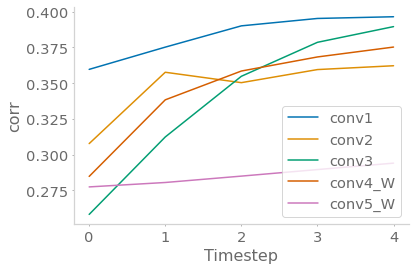

In [21]:
key = 'corr'
plt.figure()
for layer in layers:
    x = np.arange(n_timestep)
    y = []
    for t in range(n_timestep):
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=layer)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel(key)
plt.show()

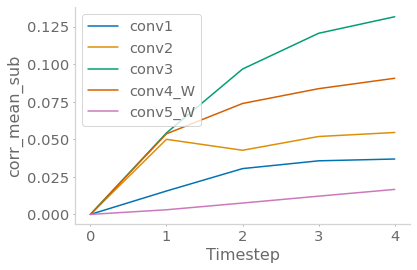

In [25]:
key = 'corr_mean_sub'
plt.figure()
for layer in layers:
    x = np.arange(n_timestep)
    y = []
    for t in range(n_timestep):
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=layer)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel(key)
plt.show()

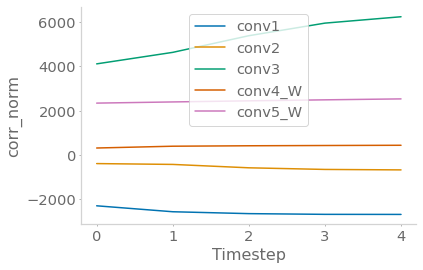

In [22]:
key = 'corr_norm'
plt.figure()
for layer in layers:
    x = np.arange(n_timestep)
    y = []
    for t in range(n_timestep):
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=layer)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel(key)
plt.show()

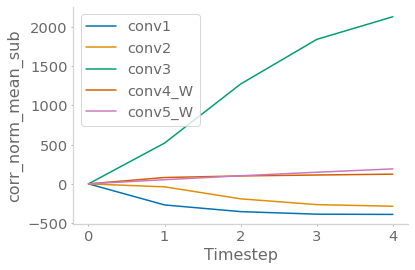

In [23]:
key = 'corr_norm_mean_sub'
plt.figure()
for layer in layers:
    x = np.arange(n_timestep)
    y = []
    for t in range(n_timestep):
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=layer)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel(key)
plt.show()

# Across Layers

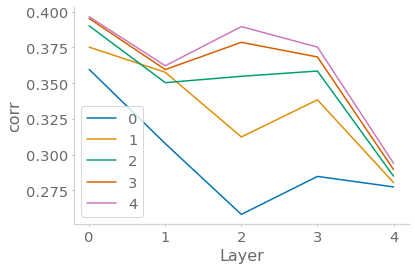

In [31]:
key = 'corr'
plt.figure()
for t in range(n_timestep):
    x = np.arange(len(layers))
    y = []
    for layer in layers:
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=t)
plt.legend()
plt.xlabel('Layer')
plt.ylabel(key)
plt.show()

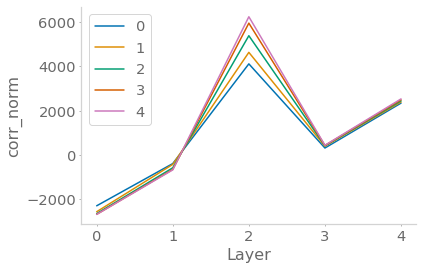

In [32]:
key = 'corr_norm'
plt.figure()
for t in range(n_timestep):
    x = np.arange(len(layers))
    y = []
    for layer in layers:
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=t)
plt.legend()
plt.xlabel('Layer')
plt.ylabel(key)
plt.show()

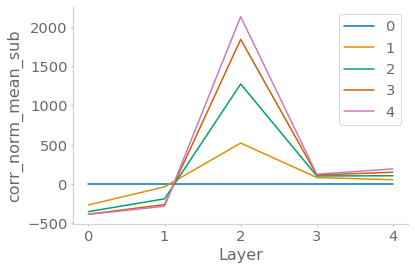

In [33]:
key = 'corr_norm_mean_sub'
plt.figure()
for t in range(n_timestep):
    x = np.arange(len(layers))
    y = []
    for layer in layers:
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=t)
plt.legend()
plt.xlabel('Layer')
plt.ylabel(key)
plt.show()

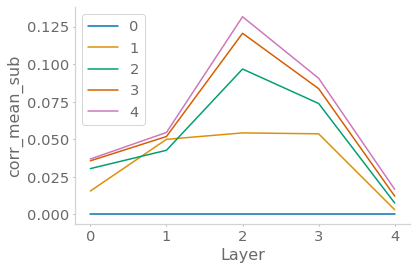

In [34]:
key = 'corr_mean_sub'
plt.figure()
for t in range(n_timestep):
    x = np.arange(len(layers))
    y = []
    for layer in layers:
        y.append(unit[layer][t][key])
    plt.plot(x, y, label=t)
plt.legend()
plt.xlabel('Layer')
plt.ylabel(key)
plt.show()